In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential

## STEP 1. Install keras

```
conda install -c conda-forge tensorflow=1.10.0
```

## STEP 2. Fashion MNIST

- Import fashion dataset
- Plot it
- Make simple NN classifier using keras
- Play with dropout and different architectures

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255

4423680/4422102 [==============================] - 1s 0us/step


How many pictures do we have?

In [3]:
X_train.shape

(60000, 28, 28)

How many clases are there?

In [13]:
from collections import Counter
Counter(y_train)

Counter({9: 6000,
         0: 6000,
         3: 6000,
         2: 6000,
         7: 6000,
         5: 6000,
         1: 6000,
         6: 6000,
         4: 6000,
         8: 6000})

Let's plot it.

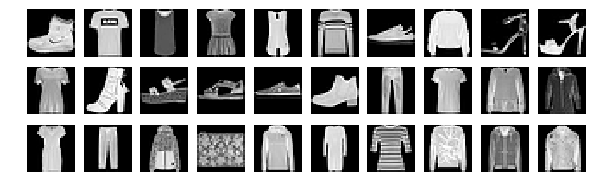

In [17]:
plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')
plt.show()

In [45]:
model = Sequential()
model.add(Flatten(input_shape=[28, 28]))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [46]:
loss = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 4s 75us/step - loss: 0.8393 - acc: 0.7254 - val_loss: 0.5770 - val_acc: 0.7940
Epoch 2/30
48000/48000 [==============================] - 5s 107us/step - loss: 0.5348 - acc: 0.8159 - val_loss: 0.4968 - val_acc: 0.8278
Epoch 3/30
48000/48000 [==============================] - 3s 62us/step - loss: 0.4857 - acc: 0.8312 - val_loss: 0.4922 - val_acc: 0.8307
Epoch 4/30
48000/48000 [==============================] - 3s 64us/step - loss: 0.4599 - acc: 0.8392 - val_loss: 0.4487 - val_acc: 0.8445
Epoch 5/30
48000/48000 [==============================] - 4s 88us/step - loss: 0.4411 - acc: 0.8447 - val_loss: 0.4391 - val_acc: 0.8458
Epoch 6/30
48000/48000 [==============================] - 3s 66us/step - loss: 0.4238 - acc: 0.8529 - val_loss: 0.4323 - val_acc: 0.8475
Epoch 7/30
48000/48000 [==============================] - 4s 82us/step - loss: 0.4111 - acc: 0.8565 - val_loss: 0.4211 - val_ac

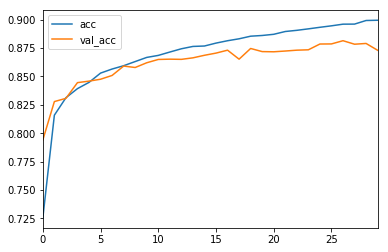

In [47]:
pd.DataFrame(loss.history)[['acc', 'val_acc']].plot()

# STEP 3

Improve model further using CNN's and use tensorboard to track training process.

In [24]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=[28, 28, 1]))
model.add(BatchNormalization(axis=-1))   # Axis -1 is always the features axis
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adadelta(),
              metrics=["accuracy"])
model.summary()

loss = model.fit(X_train[:, :, :, np.newaxis], y_train, epochs=20, validation_split=0.2)

pd.DataFrame(loss.history)[['acc', 'val_acc']].plot()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
activation_12 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)       

KeyboardInterrupt: 

## Transfer learning

Let's reuse a part of already trained model. First we need to reshape data to have same number of pixels and introduce color channels (we will simply replicate our entries since we have b/w images).

In [42]:
X_train_reshaped = tf.image.resize(np.stack([X_train]*3, axis=3), [224, 224])
X_test_reshaped = tf.image.resize(np.stack([X_test]*3, axis=3), [224, 224])

We will base our model on Xception.

In [43]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(10, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

In [44]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train_reshaped, y_train, epochs=5, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
 1024/48000 [..............................] - ETA: 1:49:17 - loss: 1.3752 - accuracy: 0.5625

KeyboardInterrupt: 

Now when it's more stable we can try to slightly tune full network weights.

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_split=0.2)